In [2]:
import numpy as np

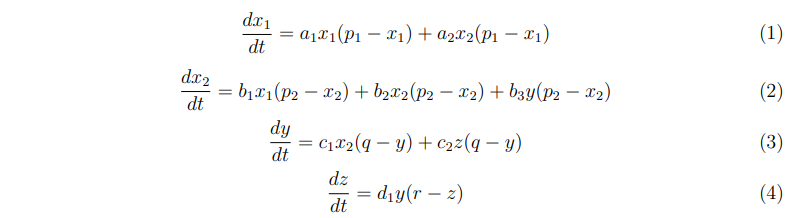

In [17]:
# Parameter dictionary
parameters = {
    # Constants
    "a1" : 10,
    "a2" : 5,
    "b1" : 5,
    "b2" : 1,
    "b3" : 1,
    "c1" : 1,
    "c2" : 1,
    "d1" : 1,

    # Population
    "p1" : 5,  # homosexual males
    "p2" : 5,  # bisexual males
    "q" : 100,  # heterosexual females
    "r" : 100, # heteroseual males
    "e" : 0.01, # transfusion rate

    "frac": 0,
    "e_frac": 0,


    "r1": 0.01, # death rate
    "r2": 0.01, # death rate
    "r3": 0.01, # death rate
    "r4": 0.01, # death rate

    "with_transfusion": False,
    "with_frac": False,
    "with_death": False,
}


def update_frac(parameters, x1, x2, y, z):
    frac = (x1, x2, y, z)/(parameters.p1 + parameters.p2 + parameters.q + parameters.r)
    parameters["frac"] = frac
    parameters["e_frac"] = parameters.e * frac


def get_equations(parameters):
    with_transfusion = parameters["with_transfusion"]
    with_frac = parameters["with_frac"]
    with_death = parameters["with_death"]


    a1 = parameters["a1"]
    a2 = parameters["a2"]
    b1 = parameters["b1"]
    b2 = parameters["b2"]
    b3 = parameters["b3"]
    c1 = parameters["c1"]
    c2 = parameters["c2"]
    d1 = parameters["d1"]

    p1 = parameters["p1"]
    p2 = parameters["p2"]
    q = parameters["q"]
    r = parameters["r"]
    e = parameters["e"] if not with_frac else parameters["e_frac"]

    r1 = parameters["r1"]
    r2 = parameters["r2"]
    r3 = parameters["r3"]
    r4 = parameters["r4"]


    
    def dx1_dt(x1, x2):
        return a1*x1*(p1-x1) + a2*x2*(p1-x1) + (e*(p1-x1) if with_transfusion else 0) - (r1*x1 if with_death else 0)

    def dx2_dt(x1, x2, y):
        return b1*x1*(p2-x2) + b2*x2*(p2-x2) + b3*y*(p2-x2) + (e*(p2-x2) if with_transfusion else 0) - (r2*x2 if with_death else 0)

    def dy_dt(x2, y, z):
        return c1*x2*(q-y) + c2*z*(q-y) + (e*(q-y) if with_transfusion else 0) - (r3*y if with_death else 0)
    def dz_dt(y, z):
        return d1*y*(r-z) + (e*(r-z) if with_transfusion else 0) - (r4*z if with_death else 0)
        
    return dx1_dt, dx2_dt, dy_dt, dz_dt
    


In [18]:

def get_stepfn(parameters, dt, mode):
    assert mode in ['euler', 'rk4'], 'mode must be either euler or rk4'

    dx1_dt, dx2_dt, dy_dt, dz_dt = get_equations(parameters)

    def step_euler(x1, x2, y, z):
        x1_new = x1 + dx1_dt(x1, x2)*dt
        x2_new = x2 + dx2_dt(x1, x2, y)*dt
        y_new  = y + dy_dt(x2, y, z)*dt
        z_new  = z + dz_dt(y, z)*dt
        return x1_new, x2_new, y_new, z_new
    
    def step_rk4(x1, x2, y, z):
        x1_new = x1 + dt*(dx1_dt(x1, x2) + 2*dx1_dt(x1, x2) + 2*dx1_dt(x1, x2) + dx1_dt(x1, x2))/6
        x2_new = x2 + dt*(dx2_dt(x1, x2, y) + 2*dx2_dt(x1, x2, y) + 2*dx2_dt(x1, x2, y) + dx2_dt(x1, x2, y))/6
        y_new = y + dt*(dy_dt(x2, y, z) + 2*dy_dt(x2, y, z) + 2*dy_dt(x2, y, z) + dy_dt(x2, y, z))/6
        z_new = z + dt*(dz_dt(y, z) + 2*dz_dt(y, z) + 2*dz_dt(y, z) + dz_dt(y, z))/6
        return x1_new, x2_new, y_new, z_new

    print(mode)

    return step_euler if mode == 'euler' else step_rk4


def simulate(parameters, x1, x2, y, z, total_time, mode = 'euler', dt = 0.001):

    stepfn = get_stepfn(parameters, dt, mode)

    total_steps = int(total_time//dt + 1)
    x_axis = np.linspace(0, total_time, total_steps)

    data = np.empty((total_steps, 5))

    data[0] = [x1, x2, y, z, 0]
    data[:,4] = x_axis
    
    for i in range(1,total_steps):
        x1, x2, y, z = stepfn(x1, x2, y, z)
        data[i][:4] = [x1, x2, y, z]

        if parameters["with_frac"]:
            update_frac(x1, x2, y, z)
            stepfn = get_stepfn(parameters, dt, mode) # Not optimal, but works. Maybe TODO: use a refence to the parameters instead of the parameters themselves 

    return data






euler
euler


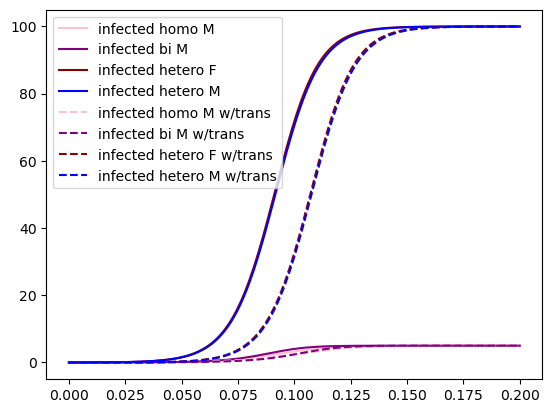

In [21]:
import matplotlib.pyplot as plt

x1 = 0.01   # infected homosexual males (p1)
x2 = 0    # infected bisexual males (p2)

y = 0  # infected heterosexual females (q)
z = 0  # infected heterosexual males (r)



data = simulate(parameters, x1, x2, y, z, 0.2, mode = 'euler', dt = 0.001)


x = data[:,4]

parameters["with_transfusion"] = False

plt.plot(x, data[:,0], label = 'infected homo M', color = "pink")
plt.plot(x, data[:,1], label = 'infected bi M', color = "purple")
plt.plot(x, data[:,2], label = 'infected hetero F', color = "darkred")
plt.plot(x, data[:,3], label = 'infected hetero M', color = "blue")



data = simulate(parameters, x1, x2, y, z, 0.2, mode = 'euler', dt = 0.001)


parameters["with_transfusion"] = True


x = data[:,4]

plt.plot(x, data[:,0], '--',label = 'infected homo M w/trans', color = "pink")
plt.plot(x, data[:,1], '--',label = 'infected bi M w/trans', color = "purple")
plt.plot(x, data[:,2], '--',label = 'infected hetero F w/trans', color = "darkred")
plt.plot(x, data[:,3], '--',label = 'infected hetero M w/trans', color = "blue")

plt.legend()
# plt.yscale("log")
plt.show()

euler
euler
euler
euler
euler


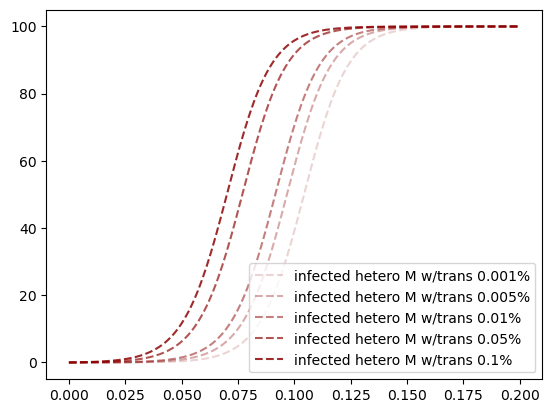

In [25]:
es = [0.001, 0.005, 0.01, 0.05, 0.1]

for i, e in enumerate(es):
    parameters["e"] = e
    parameters["with_transfusion"] = True
    data = simulate(parameters, x1, x2, y, z, 0.2, mode = 'euler', dt = 0.001)

    plt.plot(x, data[:,3], '--',label = f'infected hetero M w/trans {e:.3}%', color = "darkred", alpha = (i + 1)/(len(es)+1))

plt.legend()
plt.show()
    